## PreProcessing

Import libraries

In [20]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

Create the variable X containing all the images of cars by resizing them to 200 * 200.



In [3]:
IMAGE_SIZE = 200

In [4]:
img_dir = "dataset\images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
#     print(f1)
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

Create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that. 

In [5]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [6]:
path = 'dataset/annotations'
text_files = ['dataset/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
#     print(i)
    y.append(resizeannotation(i))

In [7]:
resizeannotation("dataset/annotations/Cars147.xml")

[168, 126, 90, 93]

In [8]:
y[0]

[167, 129, 90, 93]

Checking X and y shape

In [9]:
np.array(X).shape

(433, 200, 200, 3)

In [10]:
np.array(y).shape

(433, 4)

And we display the first eighteen image of the dataset : 

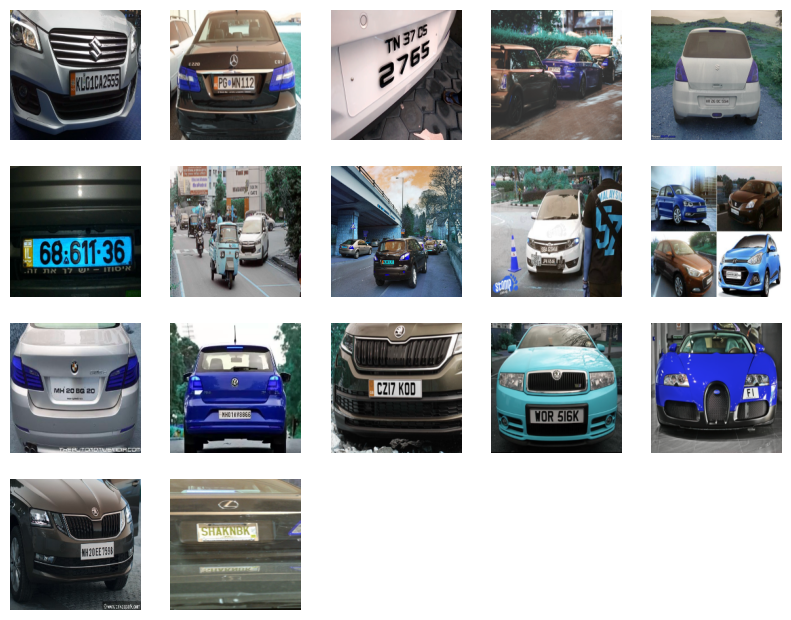

In [11]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

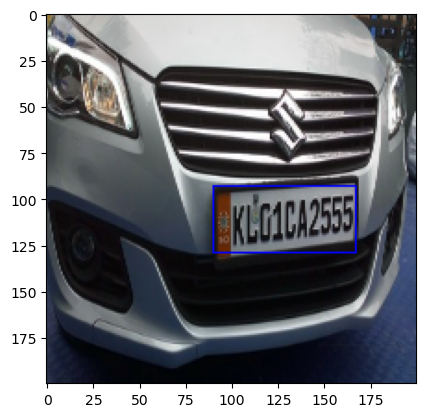

In [12]:
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


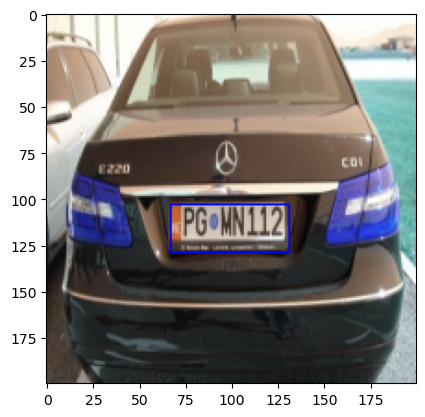

In [13]:
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


We prepare the data for the CNN :

In [14]:
X=np.array(X)
y=np.array(y)

In [15]:
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [17]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [18]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 17,099,140
Trainable params: 2,384,452
Non

In [ ]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('models/imagenet_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[mc])

Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.4910
Epoch 1: val_accuracy improved from -inf to 0.52273, saving model to models\imagenet_model.h5
13/13 [==============================] - 60s 5s/step - loss: 0.0300 - accuracy: 0.4910 - val_loss: 0.0155 - val_accuracy: 0.5227
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.6093
Epoch 2: val_accuracy improved from 0.52273 to 0.59091, saving model to models\imagenet_model.h5
13/13 [==============================] - 56s 4s/step - loss: 0.0111 - accuracy: 0.6093 - val_loss: 0.0078 - val_accuracy: 0.5909
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.6427
Epoch 3: val_accuracy improved from 0.59091 to 0.84091, saving model to models\imagenet_model.h5
13/13 [==============================] - 56s 4s/step - loss: 0.0060 - accuracy: 0.6427 - val_loss: 0.0070 - val_accuracy: 0.8409
Epoch 4/50
13/13 [=========================

In [ ]:
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1, callbacks=[mc])

In [ ]:
model = load_model('models/imagenet_model.h5')

In [ ]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

In [ ]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

In [ ]:
plot_scores(train)

## DETECTION 

In [ ]:
X_test

In [ ]:
y_cnn = model.predict(X_test)

In [ ]:
y_cnn.shape

We can see how our model localize license plates on our testing set :

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)



In [ ]:
img_dir = "Indian Number Plates\train" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
validate_X=[]
for f1 in files[:10]:
#     print(f1)
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    validate_X.append(np.array(img))

## Validation

In [ ]:
validate_X = []
folder = "Verification"
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename))
    if img is not None:
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        validate_X.append(img)

In [ ]:
plt.figure(figsize=(10,20))
for i in range(0, len(validate_X)) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(validate_X[i])

In [ ]:
validate_X=np.array(validate_X)

In [ ]:
validate_X = validate_X / 255

In [ ]:
validate_X[:10]

In [ ]:
y_verify_cnn = model.predict(validate_X)

In [ ]:
y_verify_cnn.shape

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,len(validate_X)) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_verify_cnn[i]*255
    image = cv2.rectangle(validate_X[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)